# E-Bikes Fullfilment Rate

April 4th, 2025

Author: Sarah Koopman

**Introduction**

This notebook investigates patterns in bike-sharing usage with a focus on predicting dock saturation—a state where no parking spaces are available at a given station. The goal is to understand when and why saturation occurs, and to evaluate how environmental (e.g., temperature, humidity) and temporal (e.g., hour, season) factors influence this demand.

The analysis centers on several key questions:
- Are users primarily riding for commuting, recreation, or other purposes?
- Does temperature play a critical role in saturation?
- What are the most influential predictors of saturation according to our models?
- What are the operational implications of false predictions?

To explore these questions, we first conduct exploratory data analysis and create meaningful features such as IdealTemp and IsMuggy to better represent rider comfort. We then evaluate four candidate models - Logistic Regression, Classification Tree, Random Forest, and Gradient Boosted Machine (GBM) — to predict dock saturation. Performance is assessed using AUC scores, train-test gap, confusion matrices, and feature importance.

The final model, a tuned Gradient Boosted Machine, provides both strong predictive accuracy and interpretability, revealing that temperature and hour of day are the strongest drivers of dock saturation. We also evaluate the business relevance of precision and recall, showing that false negatives (predicting a dock is available when it's not) pose greater risks to customer satisfaction and operational efficiency.

**The Analysis will include the following elements:**
1. Packages and Data imports
2. Descriptive Statistics \
    2.1 Exploratory Data Analysis \
    2.2 Missing Value Imputation \
    2.3 Feature Engineering 
3. Candidate Model Selection  \
    3.1 Logistic Regression \
    3.2 Classification Tree \
    3.3 Random Forest \
    3.4 Gradient Boosted Machine 
 4. Final Model Selection
 5. Analysis Questions

## 1. Packages and Data Imports

In [1]:
#Loading required packages for this case study

# importing libraries
import pandas as pd                                    # data science essentials
import matplotlib.pyplot as plt                        # data viz
import seaborn as sns                                  # enhanced data viz
import statsmodels.formula.api as smf                  # linear modeling
from   sklearn.model_selection import train_test_split # train/test split
import sklearn.linear_model                            # faster linear modeling
import numpy as np                                     # mathematical essentials
import phik                                            # phi coefficient

# preprocessing and testing
from sklearn.preprocessing import power_transform    # yeo-johnson
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.model_selection import train_test_split # train-test split
from sklearn.metrics import roc_curve
from sklearn.metrics import (confusion_matrix,
                             roc_auc_score, precision_score, recall_score)

import warnings                                   # warnings from code
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots
from sklearn.model_selection import RandomizedSearchCV # hp tuning
from sklearn.metrics import make_scorer                # customizable scorer

# machine learning
from sklearn.tree import DecisionTreeClassifier         # classification trees
from sklearn.tree import plot_tree                      # tree plots
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm


# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# suppressing warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
########################################
# standard_scaler
########################################
def standard_scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df



########################################
## visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

In [3]:
# Uploading the data
# specifying the path and file name
file = './bikes.xlsx'


# reading the file into Python
bikes = pd.read_excel(io     = file,
                        header = 0   )

# checking the first rows of the file
bikes.head(n = 10)

,ID,Month,Day of Week,Hour,Temperature,Humidity,Wind Speed,Visibility,Dew Point Temperature,UV Index,Precipitation,Seasons,Holiday,SATURATED
0,1,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,Winter,Yes,0
1,2,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,Winter,Yes,0
2,3,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,Winter,Yes,0
3,4,Jan,Sunday,20,-0.3,40,1.2,1936,-12.2,0.00,0.0,Winter,Yes,0
4,5,Jan,Monday,0,-1.8,54,1.1,1772,-9.8,0.00,0.0,Winter,No,0
5,6,Jan,Monday,5,-3.1,67,0.6,1384,-8.3,0.00,0.0,Winter,No,0
6,7,Jan,Monday,6,-3.2,67,0.4,1409,-8.4,0.00,0.0,Winter,No,0
7,8,Jan,Monday,7,-3.2,69,0.5,1249,-8.0,0.00,0.0,Winter,No,0
8,9,Jan,Monday,12,0.9,29,1.9,1761,-15.1,0.88,0.0,Winter,No,0
9,10,Jan,Monday,14,1.7,20,4.4,1995,-18.9,0.91,0.0,Winter,No,0


In [4]:
# reviewing the column names
bikes.columns

# information on the dataset columns and datatypes
bikes.info()

# information on the numerical data in the dataset
bikes.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1356 entries, 0 to 1355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     1356 non-null   int64  
 1   Month                  1356 non-null   object 
 2   Day of Week            1356 non-null   object 
 3   Hour                   1356 non-null   int64  
 4   Temperature            1356 non-null   float64
 5   Humidity               1356 non-null   int64  
 6   Wind Speed             1356 non-null   float64
 7   Visibility             1356 non-null   int64  
 8   Dew Point Temperature  1356 non-null   float64
 9   UV Index               1356 non-null   float64
 10  Precipitation          1356 non-null   float64
 11  Seasons                1356 non-null   object 
 12  Holiday                1356 non-null   object 
 13  SATURATED              1356 non-null   int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 148.4+ 

,ID,Hour,Temperature,Humidity,Wind Speed,Visibility,Dew Point Temperature,UV Index,Precipitation,SATURATED
count,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000
mean,678.500000,11.468289,12.746681,59.163717,1.700074,1419.502212,4.142699,0.548872,0.185029,0.488938
std,391.587793,6.943506,11.862988,20.891172,1.003253,616.608126,13.092783,0.858381,0.787694,0.500062
min,1.000000,0.000000,-16.900000,0.000000,0.000000,33.000000,-28.300000,0.000000,0.000000,0.000000
25%,339.750000,5.000000,2.975000,43.000000,0.900000,924.500000,-5.025000,0.000000,0.000000,0.000000
50%,678.500000,12.000000,13.200000,58.000000,1.500000,1665.000000,5.000000,0.010000,0.000000,0.000000
75%,1017.250000,18.000000,22.900000,76.000000,2.300000,1996.000000,15.500000,0.870000,0.000000,1.000000
max,1356.000000,23.000000,37.900000,98.000000,6.900000,2000.000000,26.100000,3.450000,12.000000,1.000000


## 2. Descriptive Statistics

### 2.1 Exploratory Data Analysis

In [5]:
# Value counts of staurated vs. non saturated - pretty 50/50 split

bikes['SATURATED'].value_counts()

SATURATED
0    693
1    663
Name: count, dtype: int64

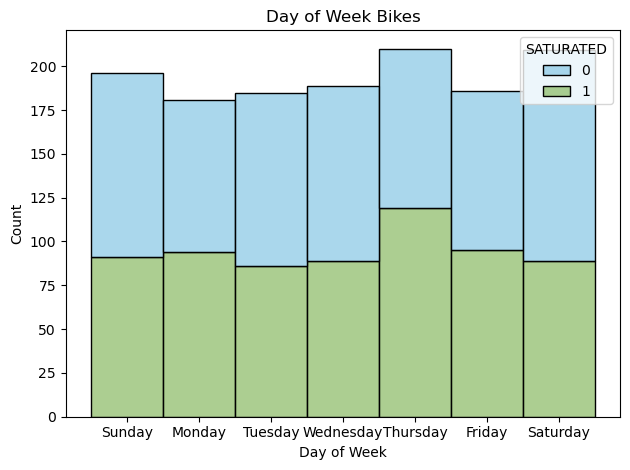

In [6]:
# histogram of values over the days of the week

# Histogram with original data
sns.histplot(   data = bikes,
                x = 'Day of Week',
                hue = 'SATURATED',
                multiple = 'stack',  # or 'dodge' to place side by side
                palette = {0: '#8ecae6', 1: '#90be6d'},
                kde = False
            )

plt.title(label = 'Day of Week Bikes')
plt.tight_layout()
plt.show()

This chart shows the distribution of saturated vs. non-saturated dock observations by day of the week. Thursday stands out with the highest total number of observations and the highest count of saturation events. Most other days have relatively balanced saturation patterns, though Tuesday and Saturday have slightly fewer saturation cases.

The relatively higher dock saturation on Thursday may suggest heavier usage patterns—possibly due to a popular "in-office" workday, hence outlining that more people commute to the office that day or commute to pre-weekend events. 



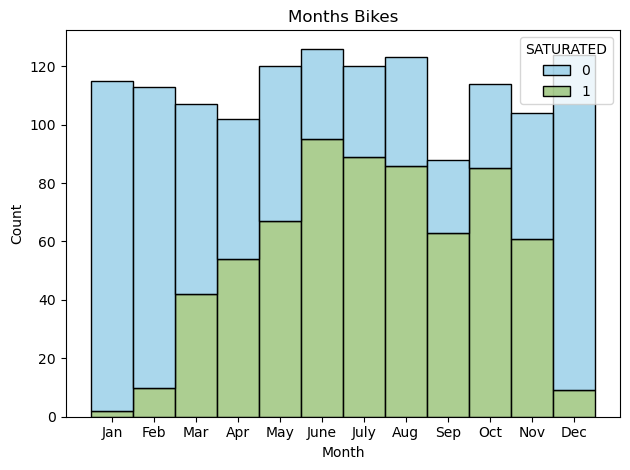

In [7]:
# histogram of values over the months of the year

# Histogram with original data
sns.histplot(   data = bikes,
                x = 'Month',
                hue = 'SATURATED',
                multiple = 'stack',  # or 'dodge' to place side by side
                palette = {0: '#8ecae6', 1: '#90be6d'},
                kde = False
            )

plt.title(label = 'Months Bikes')
plt.tight_layout()
plt.show()

This chart shows how dock saturation varies by month across the year. Saturation is much lower in winter months (Jan–Mar, Dec), likely due to colder or rainier weather reducing bike usage. Saturation peaks in late spring and summer (May–Aug), especially in June and July, when both bike usage and dock saturation are high. This seasonal trend aligns with better weather and increased recreational or commuting activity in warmer months.

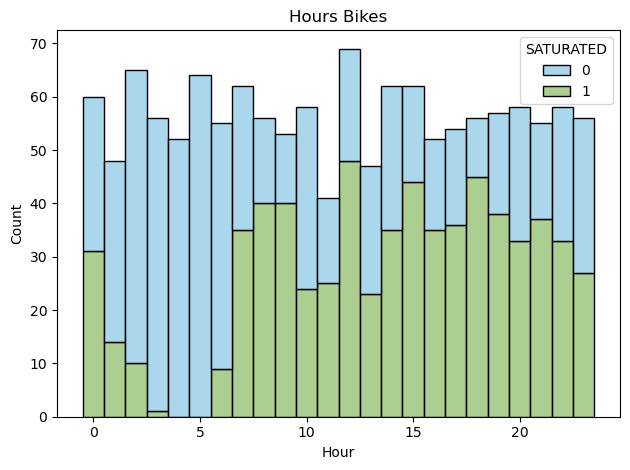

In [8]:
# histogram of values over hours of the day

# Histogram with original data
sns.histplot(   data = bikes,
                x = 'Hour',
                hue = 'SATURATED',
                multiple = 'stack',  # or 'dodge' to place side by side
                palette = {0: '#8ecae6', 1: '#90be6d'},
                kde = False , 
                discrete = True
            )

plt.title(label = 'Hours Bikes')
plt.tight_layout()
plt.show()

This chart illustrates how dock saturation varies across different hours of the day. There is a noticeable dip in saturation during the early morning (around 2–6 AM), likely due to low overall usage. Saturation starts to increase from 7 AM and remains relatively high throughout the day, with small peaks around midday and early evening. These trends may reflect both commuting and recreational patterns, especially during lunch and post-work hours.

Average Temperature (Saturated): 19.68
Average Temperature (Not Saturated): 6.11


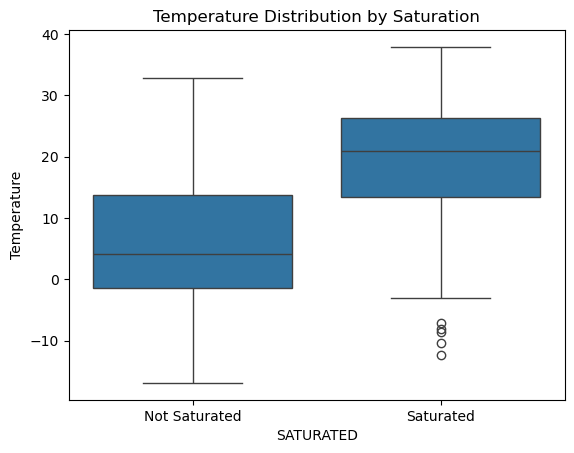

In [9]:
# Split the data by saturation outcome
saturated = bikes[bikes["SATURATED"] == 1]
not_saturated = bikes[bikes["SATURATED"] == 0]

# Compare mean and distribution of temperatures
print("Average Temperature (Saturated):", saturated["Temperature"].mean().round(2))
print("Average Temperature (Not Saturated):", not_saturated["Temperature"].mean().round(2))

sns.boxplot(x="SATURATED", y="Temperature", data=bikes)
plt.xticks([0, 1], ['Not Saturated', 'Saturated'])
plt.title("Temperature Distribution by Saturation")
plt.show()

Looking at the temperature distribution by saturation status, we observe that temperatures in the dataset range from approximately -15°C to nearly 40°C. Although the data dictionary specifies that temperature is measured in Fahrenheit, this distribution more closely resembles a Celsius scale. Therefore, we infer that Celsius is the actual unit used.

The plot reveals a clear distinction between saturated and non-saturated docks. Saturated docks tend to occur at higher temperatures, with a central range roughly between 15°C and 25°C, whereas non-saturated docks are more common at lower temperatures, particularly below 10°C.

This aligns with intuitive expectations: people are less likely to bike — especially for commuting — when it’s cold outside. Warmer weather is more conducive to riding, making dock saturation more likely during milder, comfortable temperatures.

### Missing Values

In [10]:
## missing values - no missing values

bikes.isnull().sum().sum()

# There seem to be no missing values in the dataset

0

### Transformations

In [11]:
# Transforming Holiday to numerical value so we can use it in the modeling

#Chekcing value counts
bikes['Holiday'].value_counts()

#transforming to 1 and 0
bikes['Holiday'] = bikes['Holiday'].map({'Yes': 1, 'No': 0})


In [12]:
## Making Dummies for Categorical Variables

# Month Dummy
month_dummies = pd.get_dummies(bikes['Month'], prefix='Month', dtype=int)
bikes = pd.concat([bikes, month_dummies], axis=1)

# Day Dummy
day_dummies = pd.get_dummies(bikes['Day of Week'], prefix='Day', dtype=int)
bikes = pd.concat([bikes, day_dummies], axis=1)

# Season Dummy
season_dummies = pd.get_dummies(bikes['Seasons'], prefix='Season', dtype=int)
bikes = pd.concat([bikes, season_dummies], axis=1)


In [13]:
# Rename two columns by removing spaces otherwise the model doesn't run
bikes.rename(columns={
    "Dew Point Temperature": "DewPointTemperature",
    "UV Index": "UVIndex",
    "Wind Speed": "WindSpeed"
}, inplace=True)

### Feature Engineering

In [14]:
# 1 Feature: Is Weekend

bikes['IsWeekend'] = bikes['Day of Week'].isin(['Saturday', 'Sunday']).astype(int)

bikes['IsWeekend'].value_counts()

IsWeekend
0    951
1    405
Name: count, dtype: int64

The IsWeekend feature helps distinguish between weekday and weekend rider behavior. Weekdays are more likely associated with commuting, while weekends often reflect recreational use. Dock saturation patterns may vary significantly between these two groups. For instance, recreational riders may cluster around parks or tourist areas on weekends. Capturing this distinction improves model accuracy and helps tailor bike redistribution strategies.

In [15]:
# 2 Feature: IsRushHour

bikes['IsRushHour'] = bikes['Hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)

bikes['IsRushHour'].value_counts()

IsRushHour
0    1023
1     333
Name: count, dtype: int64

The IsRushHour feature captures peak commuting times when bike usage is typically highest. It includes morning (7–9 AM) and evening (4–6 PM) hours when people travel to and from work. These periods often see surges in demand at residential and business district stations. Recognizing rush hour patterns can help predict dock saturation more accurately. This insight is key for improving rebalancing and enhancing user experience during peak times.

In [16]:
# 3 Feature: Mugginess

# Step 1 is to calculate the spread between Temp and Dew Point Temp
bikes['DewPointSpread'] = bikes['Temperature'] - bikes['DewPointTemperature']

# Then we set a Mugginess threshold at 10 to  better understand how the temp feels
bikes['IsMuggy'] = (bikes['DewPointSpread'] < 5.5).astype(int)


The IsMuggy feature captures how uncomfortably humid the air feels by measuring the difference between air temperature and dew point temperature. Unlike relative humidity, which depends on both temperature and moisture, this variable reflects absolute moisture and is a better indicator of perceived discomfort.

We define “muggy” conditions as those where the temperature is within 5.5°C of the dew point, based on meteorological standards. At this threshold, the air is nearly saturated, making it harder for sweat to evaporate — especially uncomfortable for physical activity like biking (National Weather Service, n.d.). By including this feature, we capture how oppressive humidity may deter riders and contribute to lower bike return rates or unexpected dock saturation.

In [17]:
# 4 Feature: IdealTemp
# Create a new binary feature 'IdealTemp' for when temperature is between 15°C and 25°C
bikes["IdealTemp"] = bikes["Temperature"].between(15, 25).astype(int)

# Check how many observations fall in the ideal range
bikes["IdealTemp"].value_counts()


IdealTemp
0    960
1    396
Name: count, dtype: int64

To explore the idea that dock saturation is most likely during moderate weather conditions, we engineered a new binary feature, IdealTemp, which is set to 1 when the temperature is between 15°C and 25°C—a range supported our initial EDA (see boxplot above). This range represents what we interpret as "ideal" cycling weather, where users are most likely to ride and thus contribute to dock saturation.

This feature aimed to simplify the non-linear relationship between temperature and saturation. However, after testing, IdealTemp showed no improvement in model performance or feature importance. The continuous Temperature variable allowed models to capture more nuanced patterns — such as gradual increases or subtle declines in saturation probability — that a binary cutoff could not. As a result, we excluded IdealTemp from the final model, retaining Temperature as the more informative predictor.

### Correlations

In [18]:
# printing all the bike column names
for val in bikes:
    print(f""" "{val}", """)

 "ID", 
 "Month", 
 "Day of Week", 
 "Hour", 
 "Temperature", 
 "Humidity", 
 "WindSpeed", 
 "Visibility", 
 "DewPointTemperature", 
 "UVIndex", 
 "Precipitation", 
 "Seasons", 
 "Holiday", 
 "SATURATED", 
 "Month_Apr", 
 "Month_Aug", 
 "Month_Dec", 
 "Month_Feb", 
 "Month_Jan", 
 "Month_July", 
 "Month_June", 
 "Month_Mar", 
 "Month_May", 
 "Month_Nov", 
 "Month_Oct", 
 "Month_Sep", 
 "Day_Friday", 
 "Day_Monday", 
 "Day_Saturday", 
 "Day_Sunday", 
 "Day_Thursday", 
 "Day_Tuesday", 
 "Day_Wednesday", 
 "Season_Autumn", 
 "Season_Spring", 
 "Season_Summer", 
 "Season_Winter", 
 "IsWeekend", 
 "IsRushHour", 
 "DewPointSpread", 
 "IsMuggy", 
 "IdealTemp", 


In [19]:
# creating a dataset with just the numeric data
bikes_num = bikes[["ID", 
                 "Hour", 
                 "Temperature", 
                 "Humidity", 
                 "WindSpeed", 
                 "Visibility", 
                 "DewPointTemperature", 
                 "UVIndex", 
                 "Precipitation", 
                 "Holiday", 
                 "SATURATED", 
                 "Month_Apr", 
                 "Month_Aug", 
                 "Month_Dec", 
                 "Month_Feb", 
                 "Month_Jan", 
                 "Month_July", 
                 "Month_June", 
                 "Month_Mar", 
                 "Month_May", 
                 "Month_Nov", 
                 "Month_Oct", 
                 "Month_Sep", 
                 "Day_Friday", 
                 "Day_Monday", 
                 "Day_Saturday", 
                 "Day_Sunday", 
                 "Day_Thursday", 
                 "Day_Tuesday", 
                 "Day_Wednesday", 
                 "Season_Autumn", 
                 "Season_Spring", 
                 "Season_Summer", 
                 "Season_Winter", 
                 "IsWeekend", 
                 "IsRushHour",
                 "DewPointSpread", 
                 "IsMuggy",
                  "IdealTemp"]]

In [20]:
# Checking the correlations for the variables with SATURATED

# We split the data into continuous and non-continuous variables for correlations
# List of continuous variables 
continuous = [
    'Temperature',
    'Humidity',
    'WindSpeed',
    'Visibility',
    'DewPointTemperature',
    'UVIndex',
    'Precipitation',
    "DewPointSpread", 
    'SATURATED'
]

# List of non-continuous variables
non_continuous = [
    'ID',
    'Month',
    'Day of Week',
    'Hour',
    'Holiday',
    'Seasons',
    'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan',
    'Month_July', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
    'Month_Oct', 'Month_Sep',
    'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
    'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday',
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
    'IsWeekend', 'IsRushHour', "IsMuggy", "IdealTemp",
    'SATURATED'
]


# We use pearson correlation for continuous data
bikes_corr = bikes[ continuous ].corr(method = 'pearson').round(decimals = 4)


# We use phi coefficient for non-continuous data
bikes_phi_corr = bikes[ non_continuous ].phik_matrix().round(decimals = 4)


# checking results
print(f"""
Point-Biserial Correlations
---------------------------
{bikes_corr.loc[ : , 'SATURATED' ].sort_values(ascending = False)}


Phi Coefficients
----------------
{bikes_phi_corr.loc[ : , 'SATURATED' ].sort_values(ascending = False)}
""")

interval columns not set, guessing: ['ID', 'Hour', 'Holiday', 'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan', 'Month_July', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'IsWeekend', 'IsRushHour', 'IsMuggy', 'IdealTemp', 'SATURATED']

Point-Biserial Correlations
---------------------------
SATURATED              1.0000
Temperature            0.5722
DewPointTemperature    0.4054
UVIndex                0.3866
DewPointSpread         0.2729
Visibility             0.2073
WindSpeed              0.1166
Humidity              -0.1975
Precipitation         -0.2158
Name: SATURATED, dtype: float64


Phi Coefficients
----------------
SATURATED        1.0000
Seasons          0.7441
Season_Winter    0.7140
ID               0.7090
Month            0.6879
Hour             0.5890
Sea

### Fixing Skewness

In [21]:
# Printing the skewness of the data
print(
"Skweness Values for original data:")
for col in bikes_num:
    skew_value = bikes_num[col][bikes_num[col] > 0].skew(axis=0).round(decimals=2)
    print(f"{col.ljust(35)} {skew_value}") 
print("-" * 50)

# It seems that only the Precipitation variable has some what high skewness hence
# For the log regression we will take the Yeo-Johnson method

Skweness Values for original data:
ID                                  0.0
Hour                                0.01
Temperature                         -0.02
Humidity                            0.08
WindSpeed                           0.81
Visibility                          -0.67
DewPointTemperature                 -0.08
UVIndex                             0.71
Precipitation                       2.49
Holiday                             0.0
SATURATED                           0.0
Month_Apr                           0.0
Month_Aug                           0.0
Month_Dec                           0.0
Month_Feb                           0.0
Month_Jan                           0.0
Month_July                          0.0
Month_June                          0.0
Month_Mar                           0.0
Month_May                           0.0
Month_Nov                           0.0
Month_Oct                           0.0
Month_Sep                           0.0
Day_Friday                        

In [22]:
# Selecting my X features (all)
x_features = ["Hour", "Temperature", "Humidity", "WindSpeed", "Visibility", 
          "DewPointTemperature", "UVIndex", "Precipitation","Holiday",
          "Month_Apr", "Month_Aug", "Month_Dec", "Month_Feb", "Month_Jan", 
          "Month_July", "Month_June", "Month_Mar", "Month_May", "Month_Nov", 
          "Month_Oct", "Month_Sep", "Day_Friday", "Day_Monday", "Day_Saturday", 
          "Day_Sunday", "Day_Thursday", "Day_Tuesday", "Day_Wednesday", 
          "Season_Autumn", "Season_Spring", "Season_Summer", "Season_Winter",
          "IsWeekend", "IsRushHour", "DewPointSpread", "IsMuggy"]


# subsetting X-data
x_data = bikes[x_features]


# yeo-johnson transformation for regressions
x_transformed = power_transform(X           = x_data,
                                method      = 'yeo-johnson',
                                standardize = True        )


# storing results as a DataFrame
x_transformed_df = pd.DataFrame(data    = x_transformed,
                                columns = list(x_data.columns))


# checking skewness results
x_transformed_df.skew().round(decimals = 2)

Hour                  -0.24
Temperature           -0.25
Humidity              -0.08
WindSpeed             -0.00
Visibility            -0.51
DewPointTemperature   -0.14
UVIndex                0.59
Precipitation          2.51
Holiday                4.48
Month_Apr              3.22
Month_Aug              2.85
Month_Dec              2.84
Month_Feb              3.02
Month_Jan              2.98
Month_July             2.90
Month_June             2.81
Month_Mar              3.13
Month_May              2.90
Month_Nov              3.18
Month_Oct              3.00
Month_Sep              3.54
Day_Friday             2.11
Day_Monday             2.16
Day_Saturday           1.92
Day_Sunday             2.02
Day_Thursday           1.91
Day_Tuesday            2.12
Day_Wednesday          2.08
Season_Autumn          1.31
Season_Spring          1.20
Season_Summer          1.03
Season_Winter          1.10
IsWeekend              0.88
IsRushHour             1.18
DewPointSpread        -0.08
IsMuggy             

In [23]:
# calculating difference in skewness to check how well transformation worked
print(f"""
Normality Improvements (Skewness)
---------------------------------
{abs(x_data.skew().round(decimals = 2)) - abs(x_transformed_df.skew().round(decimals = 2))}""")


Normality Improvements (Skewness)
---------------------------------
Hour                  -0.23
Temperature           -0.09
Humidity              -0.01
WindSpeed              0.79
Visibility             0.16
DewPointTemperature    0.18
UVIndex                0.98
Precipitation          4.45
Holiday                0.00
Month_Apr              0.00
Month_Aug              0.00
Month_Dec              0.00
Month_Feb              0.00
Month_Jan              0.00
Month_July             0.00
Month_June             0.00
Month_Mar              0.00
Month_May              0.00
Month_Nov              0.00
Month_Oct              0.00
Month_Sep              0.00
Day_Friday             0.00
Day_Monday             0.00
Day_Saturday           0.00
Day_Sunday             0.00
Day_Thursday           0.00
Day_Tuesday            0.00
Day_Wednesday          0.00
Season_Autumn          0.00
Season_Spring          0.00
Season_Summer          0.00
Season_Winter          0.00
IsWeekend              0.00
IsRushH

## Candidate Model Development

In [24]:
####################
## tuning_results ##
####################
def tuning_results(cv_results, n=5):
    """
    This function will display the top "n" models from hyperparameter tuning,
    based on "rank_test_score".

    PARAMETERS
    ----------
    cv_results = results dictionary from the attribute ".cv_results_"
    n          = number of models to display
    """
    param_lst = []

    for result in cv_results["params"]:
        result = str(result).replace(":", "=")
        param_lst.append(result[1:-1])


    results_df = pd.DataFrame(data = {
        "Model_Rank" : cv_results["rank_test_score"],
        "Mean_Test_Score" : cv_results["mean_test_score"],
        "SD_Test_Score" : cv_results["std_test_score"],
        "Parameters" : param_lst
    })


    results_df = results_df.sort_values(by = "Model_Rank", axis = 0)
    return results_df.head(n = n)


#####################
## sklearn_summary ##
#####################
def classification_summary(x,
                           y,
                           model,
                           model_name   = "",
                           results_df   = None,
                           tt_split     = True,
                           test_size    = 0.25,
                           scale        = False,
                           full_tree    = False,
                           random_state = 702):
    """  
    This function is designed to generate summary statistics for the following
    classification models from scikit-learn:
    * LogisticRegression         - Logistic Regression
    * DecisionTreeClassifier     - Classification Tree
    * RandomForestClassifier     - Random Forest
    * GradientBoostingClassifier - Gradient Boosted Machine


    Additional Functionality
    ------------------------
    This function will standardize the data using StandardScaler() and create
    training and testing sets using train-test split, stratifying the
    y-variable.
    
    It will also output a tabular confusion matrix, calculate area under the
    ROC curve (AUC) for the training and testing sets, as well as the train-
    test gap.
    

    PARAMETERS
    ----------
    x            | array     | X-data before train-test split | No default.
    y            | array     | y-data before train-test split | No default.
    model        | model     | model object to instantiate    | No default.
    model_name   | str       | option to name the model       | Default = ""
    results_df   | DataFrame | place to store model results   | Default = None
    test_size    | float     | test set proportion            | Default = 0.25
    scale        | bool      | whether to scale the data      | Default = False
    random_state | int       | seed for train-test split      | Default = 702
    """
    
    ###########
    # scaling #
    ###########
    
    if scale == True:
        # instantiating a StandardScaler() object
        scaler = StandardScaler(copy = True)


        # FITTING the scaler with the data
        scaler.fit(x)

        # TRANSFORMING our data after fit
        x_scaled = scaler.transform(x)

        # converting scaled data into a DataFrame
        x_scaled_df = pd.DataFrame(x_scaled)

        # reattaching column names
        x_scaled_df.columns = list(x.columns)

        # reverting back to x as the DataFrame's name
        x = x_scaled_df
    
    
    ####################
    # train-test split #
    ####################
    # standard train-test split
    x_train, x_test, y_train, y_test = train_test_split(x, # x
                                                        y, # y
                                                        test_size    = test_size,
                                                        random_state = random_state,
                                                        stratify     = y)
    
    
    #########################
    # fit - predict - score #
    #########################
    # fitting to training data
    model_fit = model.fit(x_train, y_train)


    # predicting on new data
    model_pred = model.predict(x_test)


    # scoring results
    model_train_auc   = round(roc_auc_score(y_true  = y_train,
                              y_score = model.predict(x_train)), ndigits = 4) # auc
    
    model_test_auc    = round(roc_auc_score(y_true  = y_test,
                              y_score = model.predict(x_test)),  ndigits = 4) # auc

    model_gap         = round(abs(model_train_auc - model_test_auc), ndigits = 4)

    
    ####################
    # confusion matrix #
    ####################
    full_tree_tn, \
    full_tree_fp, \
    full_tree_fn, \
    full_tree_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

    
    ###########################
    # storing/showing results #
    ###########################
    # instantiating a list to store model results
    results_lst = [ model_name, model_train_auc, model_test_auc, model_gap ]

    # converting to DataFrame
    results_lst = pd.DataFrame(data = results_lst)

    # transposing (rotating) DataFrame
    results_lst = np.transpose(a = results_lst)
    
    # if no results DataFrame provided
    if results_df == None:

        # concatenating to coef_df
        results_df = pd.DataFrame(data = results_lst)
    
    # if results DataFrame provided
    else:
        
        # concatenating to coef_df
        results_df = pd.concat(objs = [results_df, results_lst],
                               axis         = 0,
                               ignore_index = True)
        
    # adding column names
    results_columns = ['Model Name', 'train_auc', 'test_auc', 'tt_gap']
    
    # renaming columns
    results_df.columns = results_columns
    
    
    print(f"""
    Results for {model_name}
    {'=' * 20}
    Model Type: {model}
    Training Samples: {len(x_train)} 
    Testing  Samples: {len(x_test)}
    
    
    Summary Statistics
    ------------------
    AUC (Train): {model_train_auc}
    AUC (Test) : {model_test_auc}
    TT Gap     : {model_gap}
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : {full_tree_tn}
    False Positives: {full_tree_fp}
    False Negatives: {full_tree_fn}
    True Positives : {full_tree_tp}
    """)
    

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export=False):
    """
    Plots the importance of features from a CART model, sorted from most to least important. (OpenAI, 2025)
    
    PARAMETERS
    ----------
    model  : trained CART model with .feature_importances_ attribute
    train  : DataFrame of training features (i.e., x_data)
    export : whether to export the plot as a .png image, default False
    """
    
    # Extract and sort feature importances
    importances = model.feature_importances_
    feature_names = train.columns
    sorted_idx = np.argsort(importances)[::-1]  # descending order

    sorted_importances = importances[sorted_idx]
    sorted_features = feature_names[sorted_idx]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(np.arange(len(sorted_features)), sorted_features)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances (Most Important at Top)")
    plt.gca().invert_yaxis()  # most important at top

    if export:
        plt.savefig("Feature_Importance_Plot.png")
    
    plt.show()
        
        
########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
    Creates a visualization of a confusion matrix.

    PARAMETERS
    ----------
    true_y : true values for the response variable
    pred_y : predicted values for the response variable
    labels : , default None
        """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    

In [25]:
# preparing to partition data
x_data = bikes_num[x_features]

y_data =  bikes_num['SATURATED']

### Logistic Regression

We will first apply the logistic regression to our data. For this we initially standardize the transformed data and then split the data in a test train split (preserving a representative balance in the y-variable). Then we create the best model dropping irrelevant x-variables.

In [26]:
# standardizing X-data (st = scaled and transformed) for logistic regression
x_data_st = standard_scaler(df = x_transformed_df)


In [27]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            x_data_st,
            y_data,
            test_size    = 0.25,
            random_state = 219, # lock in random pattern, so other people can see and replicate our results
            stratify     = y_data) # preserving balance


# merging training data for statsmodels
bikes_train = pd.concat([x_train, y_train], axis = 1)


## this code will not produce an output ##

In [28]:
# instantiating a logistic regression model object
logistic_small = smf.logit(formula   = """ SATURATED ~ Hour + 
                                                         Humidity + 
                                                         DewPointTemperature + 
                                                         Precipitation + 
                                                         Holiday + 
                                                         Month_Aug + 
                                                         Month_Feb + 
                                                         Month_Jan + 
                                                         Month_Nov + 
                                                         Month_Oct + 
                                                         Day_Monday +
                                                         IsWeekend + 
                                                         IsRushHour + 
                                                         DewPointSpread""",
                           data = bikes_train)


# FITTING the model object
results_logistic = logistic_small.fit()


# checking the results SUMMARY
results_logistic.summary2() # summary2() has AIC and BIC

Optimization terminated successfully.
         Current function value: 0.272962
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:               Logit            Method:           MLE        
Dependent Variable:  SATURATED        Pseudo R-squared: 0.606      
Date:                2025-04-03 14:01 AIC:              585.2038   
No. Observations:    1017             BIC:              659.0730   
Df Model:            14               Log-Likelihood:   -277.60    
Df Residuals:        1002             LL-Null:          -704.67    
Converged:           1.0000           LLR p-value:      2.8722e-173
No. Iterations:      8.0000           Scale:            1.0000     
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -0.3768   0.1308 -2.8812 0.0040 -0.6332 -0.1205
Hour                 0.8776   0.1153  7.6142 0.0000  0.6517  1.1035
Humidity             2.8782   1.4341  2.0070 0.0447  0.0675  5.6890
DewPointTemperature  2.3025   0.3176  7.2507 0.0000  1.6801  2.9249
Precipitation       -0.8739   0.2007 -4.3535 0.0000 -1.2673 -0.4805
Holiday             -0.2091   0.1077 -1.9412 0.0522 -0.4203  0.0020
Month_Aug           -0.3814   0.1230 -3.1012 0.0019 -0.6224 -0.1403
Month_Feb           -0.3438   0.1449 -2.3730 0.0176 -0.6278 -0.0598
Month_Jan           -0.6613   0.2237 -2.9562 0.0031 -1.0998 -0.2229
Month_Nov            0.4878   0.1045  4.6692 0.0000  0.2830  0.6925
Month_Oct            0.5047   0.1059  4.7669 0.0000  0.2972  0.7122
Day_Monday          -0.1139   0.1164 -0.9788 0.3277 -0.3420  0.1142
IsWeekend           -0.3465   0.1160 -2.9871 0.0028 -0.5739 -0.1192
IsRushHour           0.9708   0.1269  7.6479 0.0000  0.7220  1.2196
DewPointSpread       4.7198   1.3311  3.5459 0.0004  2.1110  7.3287
===================================================================

"""

In [29]:
x_data_log = bikes[["Hour", "Humidity", "DewPointTemperature", "Precipitation",
                   "Holiday", "Month_Aug", "Month_Feb", "Month_Jan", "Month_Nov"
                   , "Month_Oct", "Day_Monday" , "IsWeekend", "IsRushHour", "DewPointSpread"]]

In [30]:
# import numpy as np
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer, roc_auc_score
# from scipy.stats import loguniform  # for the C parameter sampling

# # Define safe combinations manually
# param_grid = [
#     {'penalty': ['l1'], 'C': loguniform(1e-4, 1e4), 'solver': ['saga'], 'l1_ratio': [None]},
#     {'penalty': ['l2'], 'C': loguniform(1e-4, 1e4), 'solver': ['saga'], 'l1_ratio': [None]},
#     {'penalty': ['elasticnet'], 'C': loguniform(1e-4, 1e4), 'solver': ['saga'], 'l1_ratio': np.linspace(0, 1, 5)},
#     {'penalty': [None], 'C': loguniform(1e-4, 1e4), 'solver': ['saga'], 'l1_ratio': [None]},
# ]

# # Instantiate model
# model = LogisticRegression(max_iter=10000, random_state=708)

# # Scorer
# scorer = make_scorer(roc_auc_score, needs_threshold=True)

# # Randomized search
# tuned_model = RandomizedSearchCV(
#                 estimator = model,
#                 param_distributions = param_grid,
#                 cv = 5,
#                 n_iter = 100,
#                 random_state = 702,
#                 scoring = scorer,
#                 error_score = 'raise'
#             )

# # Fit model
# tuned_model.fit(x_data_log, y_data)

# # Results
# print("Tuned Parameters  :", tuned_model.best_params_)
# print("Tuned Training AUC:", tuned_model.best_score_.round(4))

In [31]:
# instantiating a classification tree
model = LogisticRegression(C            = 0.18703965889102797,
                           l1_ratio     = 0.5,
                           penalty      = 'elasticnet',
                           solver       = 'saga',
                           random_state = 708)

# using the classification_summary function
classification_summary(x          = x_data,
                       y          = y_data,
                       model      = model,
                       model_name = "Logistics Regression Tree")


    Results for Logistics Regression Tree
    Model Type: LogisticRegression(C=0.18703965889102797, l1_ratio=0.5, penalty='elasticnet',
                   random_state=708, solver='saga')
    Training Samples: 1017 
    Testing  Samples: 339
    
    
    Summary Statistics
    ------------------
    AUC (Train): 0.8343
    AUC (Test) : 0.8046
    TT Gap     : 0.0297
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : 145
    False Positives: 28
    False Negatives: 38
    True Positives : 128
    


**Interpretation:**

- **AUC SCORE: 0.8046**
- **TT Gap: 0.0297**

The logistic regression model achieved a test AUC of 0.8075, indicating moderately strong predictive performance with a small Train-Test Gap. Temperature stands out as the dominant predictor, likely because it directly influences outdoor activity and thus bike usage. Season_Winter and DewPointSpread also rank highly, suggesting that seasonal weather patterns and air moisture gradients significantly affect demand. The influence of Hour and IsRushHour reflects temporal dynamics in human movement, such as commuting behavior. Meanwhile, many calendar-related variables like days of the week or specific months have been excluded by the model, implying that they either offer redundant information or lack consistent predictive value across the dataset.

### Classification Tree

We use the initial user defined functions (as given by the scripts in class) to get the summary statistics of our model. We initially prepare the data for ...

In [32]:
# # developing hyperparameter ranges
# criterion_range = ["gini", "entropy", "log_loss"] # criterion
# splitter_range  = ["best", "random"] # splitter
# depth_range     = list(range(2, 16))  # max_depth
# leaf_range      = np.arange(1, 151, 15)  # min_samples_leaf


# # creating a hyperparameter grid
# param_grid = {'criterion' : criterion_range,
#               'splitter' : splitter_range,
#               'max_depth' : depth_range,
#               'min_samples_leaf' : leaf_range}


# # INSTANTIATING the model object without hyperparameters
# model = DecisionTreeClassifier(random_state = 708)


# # RandomizedSearchCV object
# tuned_model = RandomizedSearchCV(estimator             = model,
#                                  param_distributions   = param_grid,
#                                  cv                    = 5,
#                                  n_iter                = 1000,
#                                  random_state          = 702,
#                                  scoring               = make_scorer(roc_auc_score,
#                                                                    needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# tuned_model.fit(x_data, y_data)


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_model.best_params_)
# print("Tuned Training AUC:", tuned_model.best_score_.round(4))

In [33]:
# instantiating a classification tree
model = DecisionTreeClassifier(splitter         = 'best',
                               min_samples_leaf = 31,
                               max_depth        = 4,
                               criterion        = 'gini',
                               random_state     = 708)

# using the classification_summary function
classification_summary(x          = x_data,
                       y          = y_data,
                       model      = model,
                       model_name = "Tuned Tree")


    Results for Tuned Tree
    Model Type: DecisionTreeClassifier(max_depth=4, min_samples_leaf=31, random_state=708)
    Training Samples: 1017 
    Testing  Samples: 339
    
    
    Summary Statistics
    ------------------
    AUC (Train): 0.8956
    AUC (Test) : 0.8934
    TT Gap     : 0.0022
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : 158
    False Positives: 15
    False Negatives: 21
    True Positives : 145
    


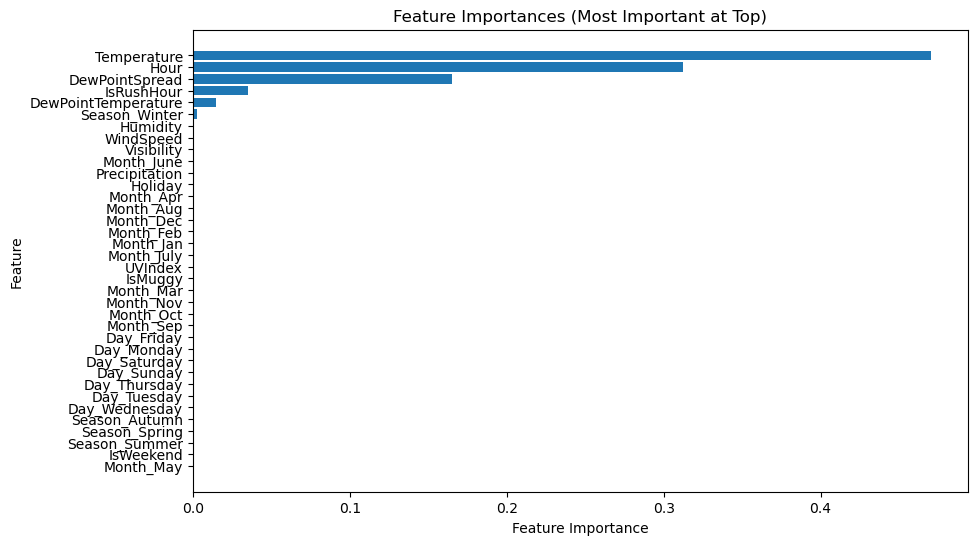

In [34]:
# plotting feature importance
plot_feature_importances(model  = model,
                         train  = x_data,
                         export = False)

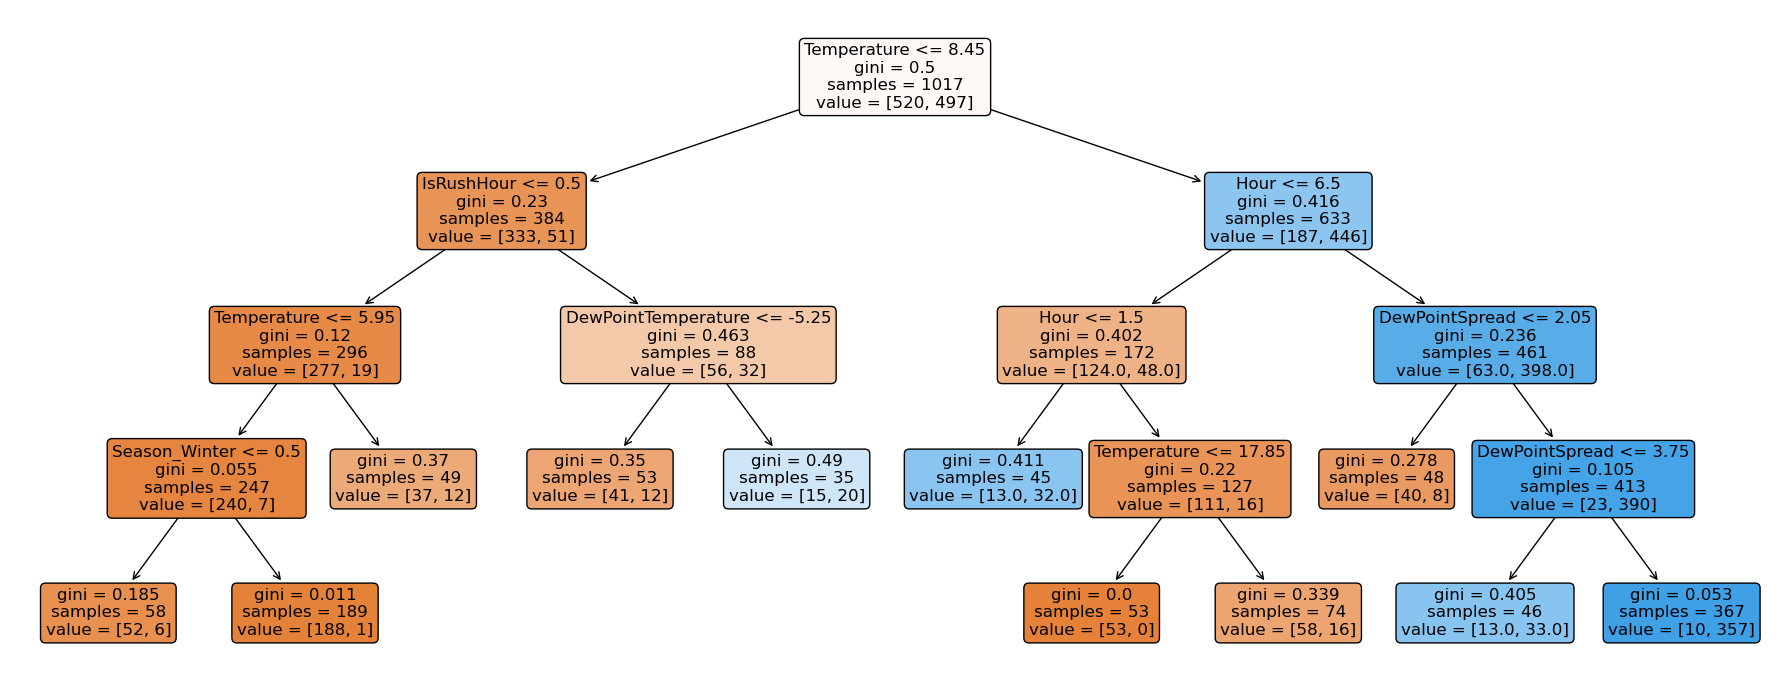

In [35]:
# setting figure size
plt.figure(figsize=(18, 7)) 


# developing a plotted tree
plot_tree(decision_tree = model,
          feature_names = x_data.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 12) 


# rendering the plot
plt.tight_layout()
plt.show()

**Interpretation:**

- **AUC SCORE: 0.8934**
- **TT Gap: 0.0022**

The tuned classification tree model (max depth = 4, min samples per leaf = 31) performed well, achieving an AUC of 0.8934 on the test set with a very small train-test gap of 0.0022, suggesting strong generalization and low overfitting.

Feature importance analysis confirms that Temperature, Hour, and DewPointSpread are the most influential variables in predicting dock saturation. This aligns with earlier findings from the logistic regression and GBM models.

Looking at the tree structure, we see that:
- Temperature is the first and most dominant split, reaffirming its central role in saturation behavior.
- The model then splits based on Hour, distinguishing between early morning, midday, and evening usage.
- Further splits use DewPointSpread, which helps capture air moisture differences—likely tied to riding comfort and weather conditions.
- Rush hour and seasonal context (e.g., winter) also appear at decision points, but with less overall weight compared to weather and time.

This structure suggests that saturation events are not driven by isolated variables, but by interactions between weather and time-of-day. For example, high saturation is most likely when temperatures are moderate (e.g., above ~8°C), during rush hours, and when the dew point spread is narrow (i.e., more humid).

These results reinforce earlier conclusions: the system is primarily used for commuting, especially during comfortable weather conditions

### Random Forrest

In [36]:
# # instantiating a hyperparameter space
# estimator_range  = np.arange(100, 1501, 100)
# leaf_range       = np.arange(1, 31, 10)
# criterion_range  = ['gini', 'entropy']
# bootstrap_range  = [True, False]
# warm_start_range = [True, False]
# max_depth        = np.arange(1, 11, 1)


# # creating a hyperparameter grid
# param_grid = {'n_estimators'     : estimator_range,
#               'min_samples_leaf' : leaf_range,
#               'criterion'        : criterion_range,
#               'bootstrap'        : bootstrap_range,
#               'warm_start'       : warm_start_range}


# # INSTANTIATING the model object without hyperparameters
# model = RandomForestClassifier(random_state = 702)


# # GridSearchCV object
# tuned_model = RandomizedSearchCV(estimator           = model,
#                                  param_distributions = param_grid,
#                                  cv                  = 5,
#                                  n_iter              = 1000,
#                                  random_state        = 702,
#                                  scoring             = make_scorer(roc_auc_score,
#                                                                    needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# tuned_model.fit(x_data, y_data)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_model.best_params_)
# print("Tuned Training AUC:", tuned_model.best_score_.round(decimals = 4))

In [37]:
# best estimators based on RandomizedSearchCV
# tuned_model.best_estimator_

In [38]:
# INSTANTIATING a random forest
model = RandomForestClassifier(n_estimators     = 300,
                               min_samples_leaf = 21,
                               criterion        = 'gini',
                               bootstrap        = False,
                               warm_start       = True,
                               random_state     = 702)

# using the classification_summary function
classification_summary(x          = x_data,
                       y          = y_data,
                       model      = model,
                       model_name = "Tuned Random Forest")


    Results for Tuned Random Forest
    Model Type: RandomForestClassifier(bootstrap=False, min_samples_leaf=21, n_estimators=300,
                       random_state=702, warm_start=True)
    Training Samples: 1017 
    Testing  Samples: 339
    
    
    Summary Statistics
    ------------------
    AUC (Train): 0.9164
    AUC (Test) : 0.9047
    TT Gap     : 0.0117
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : 164
    False Positives: 9
    False Negatives: 23
    True Positives : 143
    


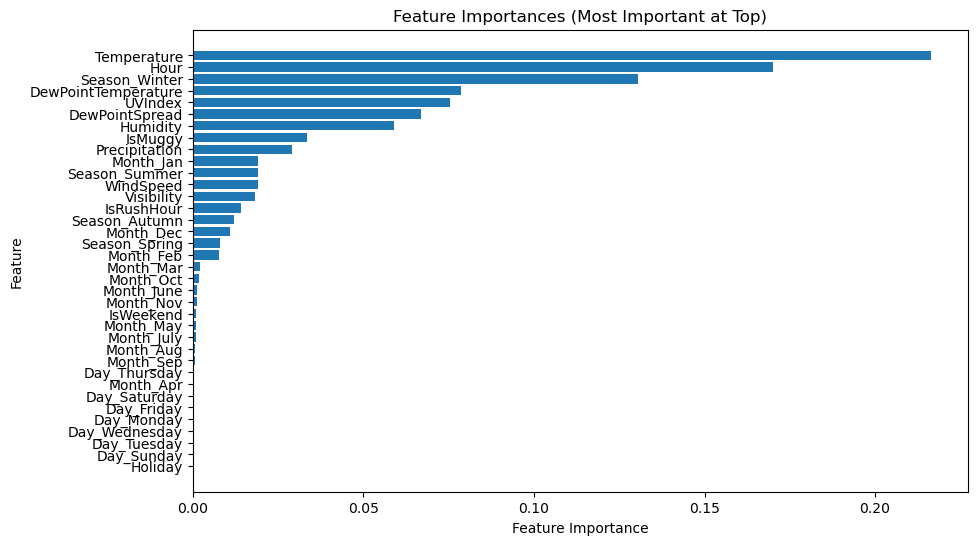

In [39]:
# plotting feature importances
plot_feature_importances(model  = model ,
                         train  = x_data,
                         export = False )

**Interpretation:**

- **AUC SCORE: 0.9047**
- **TT Gap: 0.0146**

This random forest model demonstrates strong predictive performance, with training and testing AUC scores around 0.9047 and a minimal train-test gap, suggesting excellent generalization. The confusion matrix shows that the model correctly identifies both classes with relatively few false positives (9) and false negatives (23). Even though the model finds low values of false positive, it would have a stronger practical impact if the false negatives were higher. As this would imply that the scenario were consumers come to drop of their biking, thinking that there is space in the dock but find that it is saturated, is minimized.

Among all features, Temperature is by far the most influential, contributing nearly half of the model's predictive power, indicating that temperature plays a central role in predicting the saturation outcome. Hour of the day is the second most important variable, reflecting the time-sensitive nature of the target behavior. Other variables like Precipitation and DewPointSpread have moderate influence, possibly capturing weather-related effects, while features like IsWeekend, Month_July, and Season_Spring play a very minor role.


### Gradient Boosted Machine 


In [40]:
# # instantiating hyperparameter ranges
# loss_range       = ['log_loss']                       # for classification
# learn_range      = np.linspace(0.01, 0.2, 10)         # learning rate from 0.01 to 0.2
# estimator_range  = np.arange(100, 501, 50)            # number of trees from 100 to 500
# criterion_range  = ['friedman_mse']                   # only valid option in sklearn
# depth_range      = np.arange(2, 8, 1)                 # tree depths from 2 to 7
# warm_start_range = [True, False]

# # creating a hyperparameter grid
# param_grid = {
#     'loss': ['log_loss'],
#     'learning_rate': np.logspace(-3, -1, 10),
#     'n_estimators': np.arange(100, 501, 50),
#     'criterion': ['friedman_mse'],
#     'max_depth': np.arange(2, 6),
#     'min_samples_leaf': np.arange(10, 101, 10),
#     'min_samples_split': np.arange(20, 201, 20),
#     'subsample': np.linspace(0.5, 1.0, 6),
#     'warm_start': [True, False]
# }

# # INSTANTIATING the model object without hyperparameters
# model = GradientBoostingClassifier(random_state=702)

# # GridSearchCV object
# tuned_model = RandomizedSearchCV(
#     estimator           = model,
#     param_distributions = param_grid,
#     cv                  = 5,
#     n_iter              = 500,  # reasonable size for randomized search
#     random_state        = 702,
#     scoring             = make_scorer(roc_auc_score, needs_threshold=False),
#     n_jobs              = -1  # use all cores
# )

# # FITTING to the FULL DATASET (due to cross-validation)
# tuned_model.fit(x_data, y_data)

# # PREDICT step is not needed

# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_model.best_params_)
# print("Tuned Training AUC:", tuned_model.best_score_.round(4))

In [41]:
# checking the best estimator for the model
# tuned_model.best_estimator_

In [42]:
# INSTANTIATING with best_estimator
model = GradientBoostingClassifier(
    warm_start    = False,
    subsample     = 1.0,
    n_estimators  = 100,
    min_samples_split = 80,
    min_samples_leaf = 4,
    max_depth     = 4,
    loss          = 'log_loss',
    learning_rate = 0.00278255940220712572,
    criterion     = 'friedman_mse',
    random_state  = 702
)

# using the classification_summary function
classification_summary(x          = x_data,
                       y          = y_data,
                       model      = model,
                       model_name = "Tuned Gradient Boosted Machine")


    Results for Tuned Gradient Boosted Machine
    Model Type: GradientBoostingClassifier(learning_rate=0.0027825594022071257, max_depth=4,
                           min_samples_leaf=4, min_samples_split=80,
                           random_state=702)
    Training Samples: 1017 
    Testing  Samples: 339
    
    
    Summary Statistics
    ------------------
    AUC (Train): 0.8991
    AUC (Test) : 0.905
    TT Gap     : 0.0059
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : 162
    False Positives: 11
    False Negatives: 21
    True Positives : 145
    


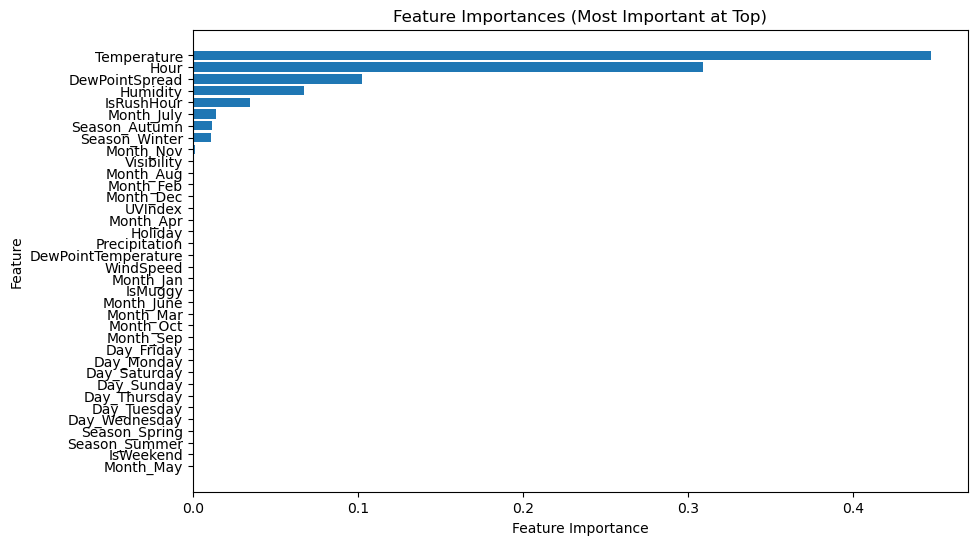

In [43]:
# plotting feature importances
plot_feature_importances(model  = model ,
                         train  = x_data,
                         export = False )

This model is our final model selected. Please see the description of our interpretation below.

## Final Model Selection

Our final model selection is the **Gradient Boosted Machine (GBM)**, which performed best across all evaluation metrics. It achieved the highest AUC score on the test set (0.905) and the smallest test-train gap (0.0059), indicating strong generalization and minimal overfitting.

What makes this model particularly effective is its ability to capture non-linear interactions between features— something we know is important given the nature of bike-sharing demand. For instance, temperature and hour of day do not act independently or linearly. The GBM is able to reflect these more complex relationships.

- **Temperature** was consistently ranked as the most important feature. The model picked up that saturation tends to occur most often when temperatures are between 15°C and 25°C—a range that aligns well with what we might expect from real-world behavior.
- **Hour** also ranked highly, with saturation events clustering around morning and evening commute times. This suggests the system is primarily used for commuting, which helps explain the recurring peaks in demand.
- Other variables, like dew point and wind, had weaker importance scores and were de-emphasized in the model — another point in favour of GBM, as it naturally assigns weight to what matters most.

In addition, the model showed high recall (87%) and high precision (93%), as shown in the confusion matrix. Meaning it performs well in both identifying true saturation events and minimizing false alarms. This is especially important given our conclusion that false negatives are more harmful from a user experience and business standpoint.

Overall, the GBM not only performs well but also helps surface meaningful insights about when and why saturation occurs — making it the best choice for both prediction and interpretability in this use case.

In [44]:
# INSTANTIATING with best_estimator
model = GradientBoostingClassifier(
    warm_start    = False,
    subsample     = 1.0,
    n_estimators  = 100,
    min_samples_split = 80,
    min_samples_leaf = 4,
    max_depth     = 4,
    loss          = 'log_loss',
    learning_rate = 0.00278255940220712572,
    criterion     = 'friedman_mse',
    random_state  = 702
)

# using the classification_summary function
classification_summary(x          = x_data,
                       y          = y_data,
                       model      = model,
                       model_name = "Tuned Gradient Boosted Machine")



    Results for Tuned Gradient Boosted Machine
    Model Type: GradientBoostingClassifier(learning_rate=0.0027825594022071257, max_depth=4,
                           min_samples_leaf=4, min_samples_split=80,
                           random_state=702)
    Training Samples: 1017 
    Testing  Samples: 339
    
    
    Summary Statistics
    ------------------
    AUC (Train): 0.8991
    AUC (Test) : 0.905
    TT Gap     : 0.0059
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : 162
    False Positives: 11
    False Negatives: 21
    True Positives : 145
    


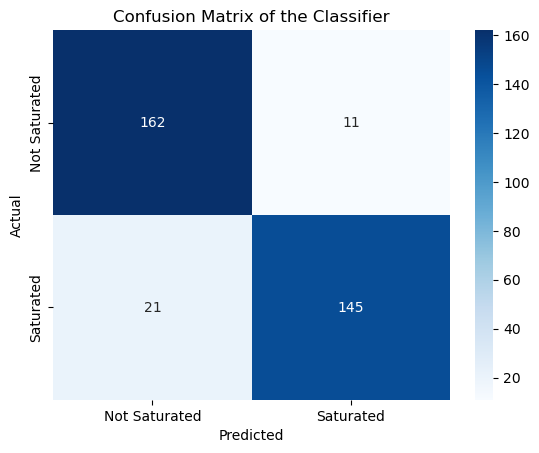

In [45]:
# Plotting the confusion Matrix
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.25,
                                                    random_state=702,
                                                    stratify=y_data)

# Fit your model
model.fit(x_train, y_train)

# Predict on the test set
y_pred = model.predict(x_test)

# Visualize confusion matrix
visual_cm(true_y=y_test,
          pred_y=y_pred,
          labels=['Not Saturated', 'Saturated'])

## Analysis Summary

**Overview of Findings:**  
Our Gradient Boosted Machine model reveals that dock saturation is overwhelmingly driven by commuting patterns—sharp morning and evening peaks (Hour, IsRushHour) far outstrip weekend or seasonal effects—and that temperature is the most powerful predictor, with usage rising through a ~15–25 °C comfort band (hence our “IdealTemp” flag) before plateauing. Monthly and seasonal indicators add little beyond these temporal and weather signals. From an operational standpoint, it’s critical to minimize false negatives (missing a full‑dock event), since unexpected saturation erodes rider trust far more than occasional false alarms. Altogether, these results produce a highly accurate, interpretable forecast that can dynamically inform repositioning strategies and improve user experience.

## Sources:

National Weather Service. (n.d.). Dew point vs. humidity. National Oceanic and Atmospheric Administration. https://www.weather.gov/tbw/dewpoint

OpenAI. (2025). ChatGPT conversation on plot feature importance. ChatGPT. https://chatgpt.com/share/67eef59e-3274-8010-8390-183fca9cc483